In [1]:
pip install tf-keras-vis

In [2]:
# Cell 1: Imports (Ensure Adam is included)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam  # <<<----- ADD THIS IMPORT
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Callbacks might not be strictly needed here, but won't hurt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Import tf-keras-vis if you intend to use it later in this notebook
try:
    from tf_keras_vis.gradcam import Gradcam
    from tf_keras_vis.utils.scores import CategoricalScore
    print("tf-keras-vis imported.")
except ImportError:
    print("tf-keras-vis not found or needs restart.")

print(f"TensorFlow Version: {tf.__version__}")
print("Initial imports done.")

# Mount Google Drive (if not already done in this session)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted.")
except:
    print("Google Drive likely already mounted or not in Colab.")

tf-keras-vis imported.
TensorFlow Version: 2.18.0
Initial imports done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


In [3]:
# --- Paths (*** VERIFY THESE ARE CORRECT FOR YOUR DRIVE ***) ---
# Folder containing 'train', 'valid', 'test' subdirectories
DATA_ROOT = '/content/drive/MyDrive/data/ct/Data'
# Main project folder where the 'models' subfolder is/will be
PROJECT_DIR = '/content/drive/MyDrive/data/ct' # <<< VERIFY/ADJUST THIS !!!

TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VALID_DIR = os.path.join(DATA_ROOT, 'valid')
TEST_DIR = os.path.join(DATA_ROOT, 'test')
MODELS_DIR = os.path.join(PROJECT_DIR, 'models')

# --- Model File Paths ---
# Path to your EXISTING saved H5 model (for loading weights)
H5_WEIGHTS_LOAD_PATH = os.path.join(MODELS_DIR, 'mobilenetv2_ct_best.h5')
# Path where the NEW Keras format model WILL BE SAVED
KERAS_MODEL_SAVE_PATH = os.path.join(MODELS_DIR, 'mobilenetv2_ct_final.keras')

# Create models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Data Root: {DATA_ROOT}")
print(f"Project Dir: {PROJECT_DIR}")
print(f"Models Dir: {MODELS_DIR}")
print(f"H5 Weights Path: {H5_WEIGHTS_LOAD_PATH} | Exists: {os.path.exists(H5_WEIGHTS_LOAD_PATH)}")
print(f"Keras Save Path: {KERAS_MODEL_SAVE_PATH}") # Will be created

assert os.path.exists(TRAIN_DIR), f"Training directory not found: {TRAIN_DIR}"
assert os.path.exists(VALID_DIR), f"Validation directory not found: {VALID_DIR}"
assert os.path.exists(TEST_DIR), f"Test directory not found: {TEST_DIR}"
assert os.path.exists(H5_WEIGHTS_LOAD_PATH), f"Weights H5 file not found: {H5_WEIGHTS_LOAD_PATH}"

# --- Parameters (Match training) ---
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32 # Ensure this matches the training batch size

print("\nPaths and parameters defined.")

Data Root: /content/drive/MyDrive/data/ct/Data
Project Dir: /content/drive/MyDrive/data/ct
Models Dir: /content/drive/MyDrive/data/ct/models
H5 Weights Path: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_best.h5 | Exists: True
Keras Save Path: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_final.keras

Paths and parameters defined.


In [4]:
print("Creating ImageDataGenerators...")
# IMPORTANT: Rescaling must match exactly what was used during training
# Augmentation is not needed here as we aren't training again, but include rescaling.
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255) # Rescale needed for class indices

print("ImageDataGenerators defined (using only rescale for now).")

# Create Train Generator (needed for class indices, even if not retraining)
print(f"\nCreating Training Generator from: {TRAIN_DIR} (for class info)")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False # No need to shuffle just for indices
)

# Create Test Generator (for evaluation/prediction later)
print(f"\nCreating Test Generator from: {TEST_DIR}")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE, # Keep consistent or use 1 for final predict
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False # IMPORTANT: Never shuffle test data
)

# --- Get Class Info ---
num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

print("\n--- Class Information ---")
print("Class Indices:", train_generator.class_indices)
print("Num Classes:", num_classes)
print("Class Labels:", class_labels)
print("\nData generators ready.")

Creating ImageDataGenerators...
ImageDataGenerators defined (using only rescale for now).

Creating Training Generator from: /content/drive/MyDrive/data/ct/Data/train (for class info)
Found 613 images belonging to 4 classes.

Creating Test Generator from: /content/drive/MyDrive/data/ct/Data/test
Found 315 images belonging to 4 classes.

--- Class Information ---
Class Indices: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}
Num Classes: 4
Class Labels: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

Data generators ready.


In [5]:
print("\nRe-creating model architecture...")
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

try:
    # 1. Build the exact same architecture
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None, # Don't load imagenet weights here, we load from H5
        pooling=None
    )
    base_model.trainable = False # Match state before training head
    print(f"Base model '{base_model.name}' created.")

    inputs = Input(shape=input_shape, name="input_layer_1") # Ensure name consistency
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x) # Match training dropout
    x = Dense(128, activation='relu')(x) # Match training dense layer
    x = Dropout(0.3)(x) # Match training dropout
    outputs = Dense(num_classes, activation='softmax', name='output_dense')(x) # Match training output
    model_recreated = Model(inputs=inputs, outputs=outputs)
    print("Model architecture re-created.")
    model_recreated.summary()

    # 2. Compile briefly (needed by some TF versions for load_weights)
    print("\nCompiling the model architecture...")
    model_recreated.compile(optimizer='adam', loss='categorical_crossentropy')
    print("Model compiled.")

    # 3. Load weights from your .h5 file
    print(f"\nLoading weights from existing H5 file: {H5_WEIGHTS_LOAD_PATH}")
    model_recreated.load_weights(H5_WEIGHTS_LOAD_PATH)
    print("Weights loaded successfully.")

    # 4. Assign to best_model variable for consistency if needed
    best_model = model_recreated
    print("Assigned loaded model to 'best_model' variable.")

    # 5. SAVE in the recommended .keras format
    print(f"\nSaving model in Keras native format to: {KERAS_MODEL_SAVE_PATH}")
    best_model.save(KERAS_MODEL_SAVE_PATH)
    print("Model successfully saved in .keras format.")

except Exception as e:
    print(f"ERROR during model recreation/loading/saving: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n--- Model Weights Loaded and Model Resaved in Keras Format ---")


Re-creating model architecture...
Base model 'mobilenetv2_1.00_224' created.
Model architecture re-created.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Compiling the model architecture...
Model compiled.

Loading weights from existing H5 file: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_best.h5
Weights loaded successfully.
Assigned loaded model to 'best_model' variable.

Saving model in Keras native format to: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_final.keras
Model successfully saved in .keras format.

--- Model Weights Loaded and Model Resaved in Keras Format ---


In [6]:
# --- Re-run necessary Imports AFTER restarting runtime ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import random
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model # Use load_model now for .keras

print("Imports re-run after restart.")

# --- Redefine necessary parameters (must match saving session) ---
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
# --- CRITICAL: Use the EXACT class labels in the CORRECT order ---
#     Get this from the output of Cell 3 if unsure.
class_labels = ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
                'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
                'normal',
                'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
print(f"Class labels (verify order!): {class_labels}")

# --- Define Paths again ---
PROJECT_DIR = '/content/drive/MyDrive/data/ct' # Verify/Adjust
MODELS_DIR = os.path.join(PROJECT_DIR, 'models')
KERAS_MODEL_LOAD_PATH = os.path.join(MODELS_DIR, 'mobilenetv2_ct_final.keras') # Path to the .keras file

# --- Load the Model saved in .keras format ---
print(f"\nLoading model from .keras file: {KERAS_MODEL_LOAD_PATH}")
if os.path.exists(KERAS_MODEL_LOAD_PATH):
    # This automatically compiles the model with its saved state if saved properly
    loaded_model = load_model(KERAS_MODEL_LOAD_PATH)
    print("Model loaded successfully from .keras format.")
    loaded_model.summary() # Verify structure
else:
    print(f"ERROR: Model file not found at {KERAS_MODEL_LOAD_PATH}")
    raise FileNotFoundError("Cannot find the saved .keras model file.")

# --- Preprocessing Function for Prediction ---
def preprocess_image_for_prediction(img_path, target_size=IMAGE_SIZE):
    """Loads and preprocesses a single image."""
    try:
        img = keras_image.load_img(img_path, target_size=target_size, color_mode='rgb')
        img_array = keras_image.img_to_array(img)
        img_array = img_array.astype(np.float32) / 255.0 # Use same scaling as training
        img_array = np.expand_dims(img_array, axis=0)
        return img_array
    except Exception as e:
        print(f"Error preprocessing image {img_path}: {e}")
        return None

# --- Prediction Function ---
def predict_ct_scan(image_path, model_to_use, labels_list):
    """Takes image path, model, labels -> returns predicted class name & score."""
    print(f"\nPredicting for image: {os.path.basename(image_path)}")
    preprocessed_img = preprocess_image_for_prediction(image_path)
    if preprocessed_img is None: return "Error Preprocessing", 0.0

    try:
        predictions = model_to_use.predict(preprocessed_img, verbose=0)
        predicted_class_index = np.argmax(predictions[0])
        confidence_score = predictions[0][predicted_class_index]
        if 0 <= predicted_class_index < len(labels_list):
            predicted_class_name = labels_list[predicted_class_index]
            print(f"-> Predicted Class: {predicted_class_name}")
            print(f"-> Confidence: {confidence_score:.4f}")
            return predicted_class_name, confidence_score
        else:
            print(f"Error: Index {predicted_class_index} out of bounds.")
            return "Index Error", 0.0
    except Exception as e:
        print(f"Error during prediction: {e}")
        return "Prediction Error", 0.0

print("\nModel loading and prediction functions ready.")

Imports re-run after restart.
Class labels (verify order!): ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

Loading model from .keras file: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_final.keras
Model loaded successfully from .keras format.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)


Model loading and prediction functions ready.


In [7]:
# Cell 5: Re-Evaluate Full Test Set

import math
import tensorflow as tf # Ensure TF is available
from tensorflow.keras.optimizers import Adam # Ensure Adam is available here too

print("\nEvaluating the loaded model on the entire test set...")

# Check if test_generator exists before proceeding
if 'test_generator' not in globals():
    print("ERROR: 'test_generator' not found. Please run the Data Generator cell (Cell 3) first.")
else:
    # Attempt to recompile with original metrics
    try:
        print("Re-compiling model with original training metrics...")
        # --- Use a reasonable learning rate assumption ---
        # You might know the final LR from training, otherwise use a small value
        # since weights are loaded, the exact initial LR matters less here than metrics
        final_lr = 1e-5 # Use the final LR if you know it from ReduceLROnPlateau log, else use a small default like 1e-5
        loaded_model.compile(
            optimizer=Adam(learning_rate=final_lr), # Now Adam is defined
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        print("Model re-compiled with specific metrics.")
    except Exception as e:
        print(f"Warning: Could not re-compile with all metrics - {e}. Proceeding with basic compile.")
        # Fallback compile if the above fails (e.g., if optimizer state wasn't fully saved)
        loaded_model.compile(loss='categorical_crossentropy', metrics=['accuracy'])


    # Calculate steps and evaluate
    try:
        test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
        print(f"Test samples: {test_generator.samples}, Batch size: {test_generator.batch_size}, Test steps: {test_steps}")

        results = loaded_model.evaluate(
            test_generator,
            steps=test_steps,
            verbose=1
        )

        print("\nTest Set Evaluation Results (Loaded .keras Model):")
        metric_names = loaded_model.metrics_names
        for name, value in zip(metric_names, results):
             print(f"- {name}: {value:.4f}") # Print clearly

    except Exception as e:
        print(f"An error occurred during evaluation: {e}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating the loaded model on the entire test set...
Re-compiling model with original training metrics...
Model re-compiled with specific metrics.
Test samples: 315, Batch size: 32, Test steps: 10
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8276 - auc: 0.9646 - loss: 0.4877 - precision: 0.8589 - recall: 0.7555

Test Set Evaluation Results (Loaded .keras Model):
- loss: 0.6181
- compile_metrics: 0.7206


In [8]:
# Cell 9: Evaluate Full Test Set

import math
import tensorflow as tf
from tensorflow.keras.optimizers import Adam # Ensure Adam is available if needed for re-compile

print("\nEvaluating the loaded model on the entire test set...")

# Ensure test_generator is available (should be from Cell 3)
if 'test_generator' not in globals() or 'loaded_model' not in globals():
    print("ERROR: 'test_generator' or 'loaded_model' not defined. Run previous cells first.")
else:
    # Optional: Recompile if you want specific metrics tracked during evaluation
    # that weren't automatically loaded with load_model from .keras
    # If load_model already restored the optimizer and metrics, this might not be needed,
    # but explicitly compiling ensures the metrics you want are used by evaluate().
    try:
        print("Attempting to re-compile model with desired metrics...")
        # Use a small LR, actual value matters less than metrics definition here
        loaded_model.compile(
            optimizer=Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        print("Model re-compiled with specific metrics.")
    except Exception as e:
        print(f"Notice: Could not re-compile model with specific metrics ({e}). Evaluate will use loaded compile state.")

    # Calculate steps needed to cover the entire test set
    test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
    print(f"Test samples: {test_generator.samples}, Batch size: {test_generator.batch_size}, Test steps: {test_steps}")

    # Run evaluation
    try:
        test_generator.reset() # Reset before evaluate
        results = loaded_model.evaluate(
            test_generator,
            steps=test_steps,
            verbose=1
        )

        print("\n--- Test Set Evaluation Results ---")
        metric_names = loaded_model.metrics_names
        for name, value in zip(metric_names, results):
             # Handle cases where metrics might be lists (e.g., per-class precision) - unlikely for evaluate()
             if isinstance(value, (list, tuple)):
                  print(f"- {name}: {np.mean(value):.4f} (Average)") # Print average if list
             else:
                  print(f"- {name}: {value:.4f}")

    except Exception as e:
        print(f"An error occurred during evaluation: {e}")


Evaluating the loaded model on the entire test set...
Attempting to re-compile model with desired metrics...
Model re-compiled with specific metrics.
Test samples: 315, Batch size: 32, Test steps: 10
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8276 - auc: 0.9646 - loss: 0.4877 - precision: 0.8589 - recall: 0.7555

--- Test Set Evaluation Results ---
- loss: 0.6181
- compile_metrics: 0.7206



Generating predictions for Classification Report and Confusion Matrix...
Predicting on 315 samples in 10 steps...
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

--- Classification Report ---
                         precision    recall  f1-score   support

         adenocarcinoma       0.63      0.89      0.74       120
   large.cell.carcinoma       0.65      0.67      0.66        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.85      0.37      0.51        90

               accuracy                           0.72       315
              macro avg       0.78      0.73      0.72       315
           weighted avg       0.76      0.72      0.70       315


--- Confusion Matrix ---
[[107   7   0   6]
 [ 17  34   0   0]
 [  0   1  53   0]
 [ 47  10   0  33]]


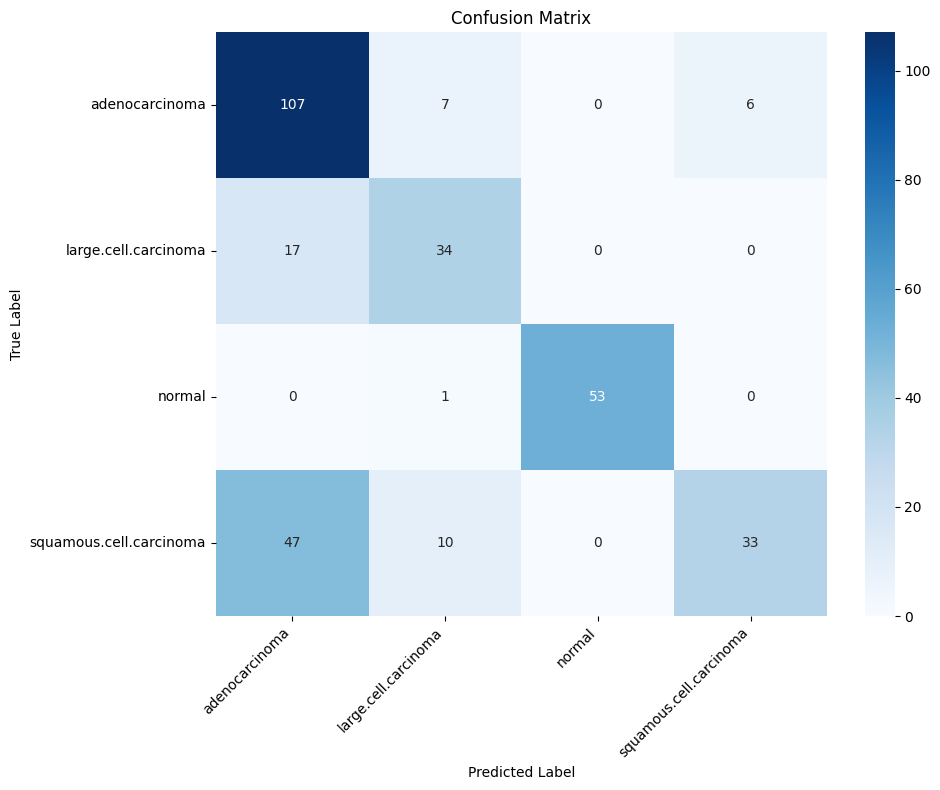

<Figure size 640x480 with 0 Axes>

In [9]:
# Cell 10/21: Detailed Analysis (Classification Report & Confusion Matrix) - ADD THIS CODE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import math

print("\nGenerating predictions for Classification Report and Confusion Matrix...")

# Ensure test_generator is reset (important!)
test_generator.reset()

# Predict on the entire test set
# Calculate steps needed to cover all samples
test_steps_detailed = math.ceil(test_generator.samples / test_generator.batch_size)
print(f"Predicting on {test_generator.samples} samples in {test_steps_detailed} steps...")
predictions = loaded_model.predict(test_generator, steps=test_steps_detailed, verbose=1)

# Get predicted class indices (highest probability)
predicted_classes = np.argmax(predictions, axis=1)

# Get true class indices
true_classes = test_generator.classes

# Get class labels from the generator
class_labels = list(test_generator.class_indices.keys()) # Should already exist, but good to have here

print("\n--- Classification Report ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Store these results if needed for a comprehensive report
report_classification_report = classification_report(true_classes, predicted_classes, target_names=class_labels, output_dict=True) # Get as dict for later use
report_confusion_matrix_fig = plt.gcf() # Get the current figure to potentially save later


--- Error Analysis: Displaying Misclassified Images ---


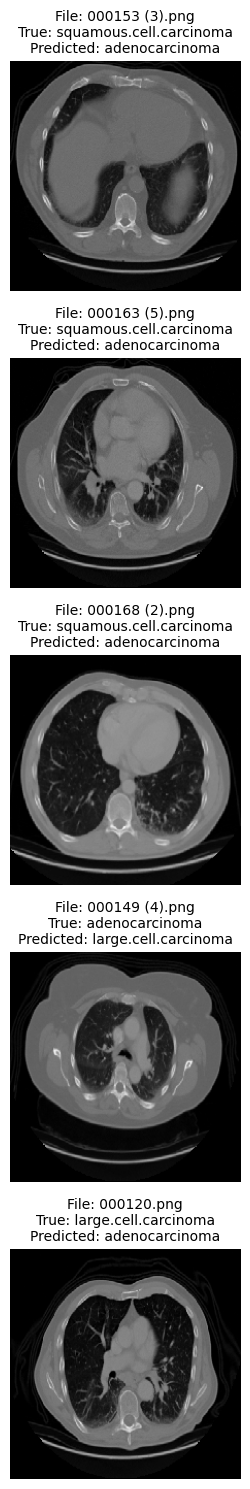

In [10]:
# Cell 11/22: Error Analysis (Manual Image Review Setup - ADD THIS CODE)
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
import random
import math

# Ensure these variables are available from Cell 10/21 execution
if 'test_generator' in globals() and 'predicted_classes' in globals() and 'true_classes' in globals() and 'class_labels' in globals():
    print("\n--- Error Analysis: Displaying Misclassified Images ---")

    filenames = test_generator.filenames
    errors = np.where(predicted_classes != true_classes)[0]
    num_errors_to_show = min(5, len(errors)) # Show up to 5 errors

    if len(errors) > 0:
        error_indices = random.sample(list(errors), num_errors_to_show)

        plt.figure(figsize=(15, 3 * num_errors_to_show))
        for i, error_idx in enumerate(error_indices):
            img_path = os.path.join(test_generator.directory, filenames[error_idx])
            original_img = keras_image.load_img(img_path, target_size=IMAGE_SIZE) # Use defined IMAGE_SIZE

            plt.subplot(num_errors_to_show, 1, i + 1)
            plt.imshow(original_img)
            true_label = class_labels[true_classes[error_idx]]
            pred_label = class_labels[predicted_classes[error_idx]]
            plt.title(f"File: {os.path.basename(img_path)}\nTrue: {true_label}\nPredicted: {pred_label}", fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No misclassifications found in the test set!")

else:
    print("ERROR: Cannot perform error analysis. Required variables (predictions, true classes) not found.")
    print("Please run the Detailed Analysis cell first.")

Setting up Grad-CAM functions (Targeting classifier input)...

Attempting CAM-like analysis targeting layer: 'dropout_1' (Output Before Final Dense)
Retrieved 5 sample files.

Processing: 6 (2).png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model created successfully.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


  Gradients calculated for class index: 2
  Non-spatial 'heatmap' (feature importance) generated, shape: (128,)
  Pred: normal (1.000) | True: normal
  Feature importance generated (shape: (128,), Min: 0.00, Max: 1.00)

Processing: 000141.png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model created successfully.
  Gradients calculated for class index: 1
  Non-spatial 'heatmap' (feature importance) generated, shape: (128,)
  Pred: large.cell.carcinoma (0.592) | True: large.cell.carcinoma
  Feature importance generated (shape: (128,), Min: 0.00, Max: 1.00)

Processing: 000124.png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model created successfully.
  Gradients calculated for class index: 0
  Non-spatial 'heatmap' (feature importance) generated, shape: (128,)
  Pred: adenocarcinoma (0.673) | True: squamous.cell.carcinoma
  Feature importance generated (shape: (128,), Min: 0.00, Max: 1.00)

Processing: 000139 (6).png
  Targeting non-

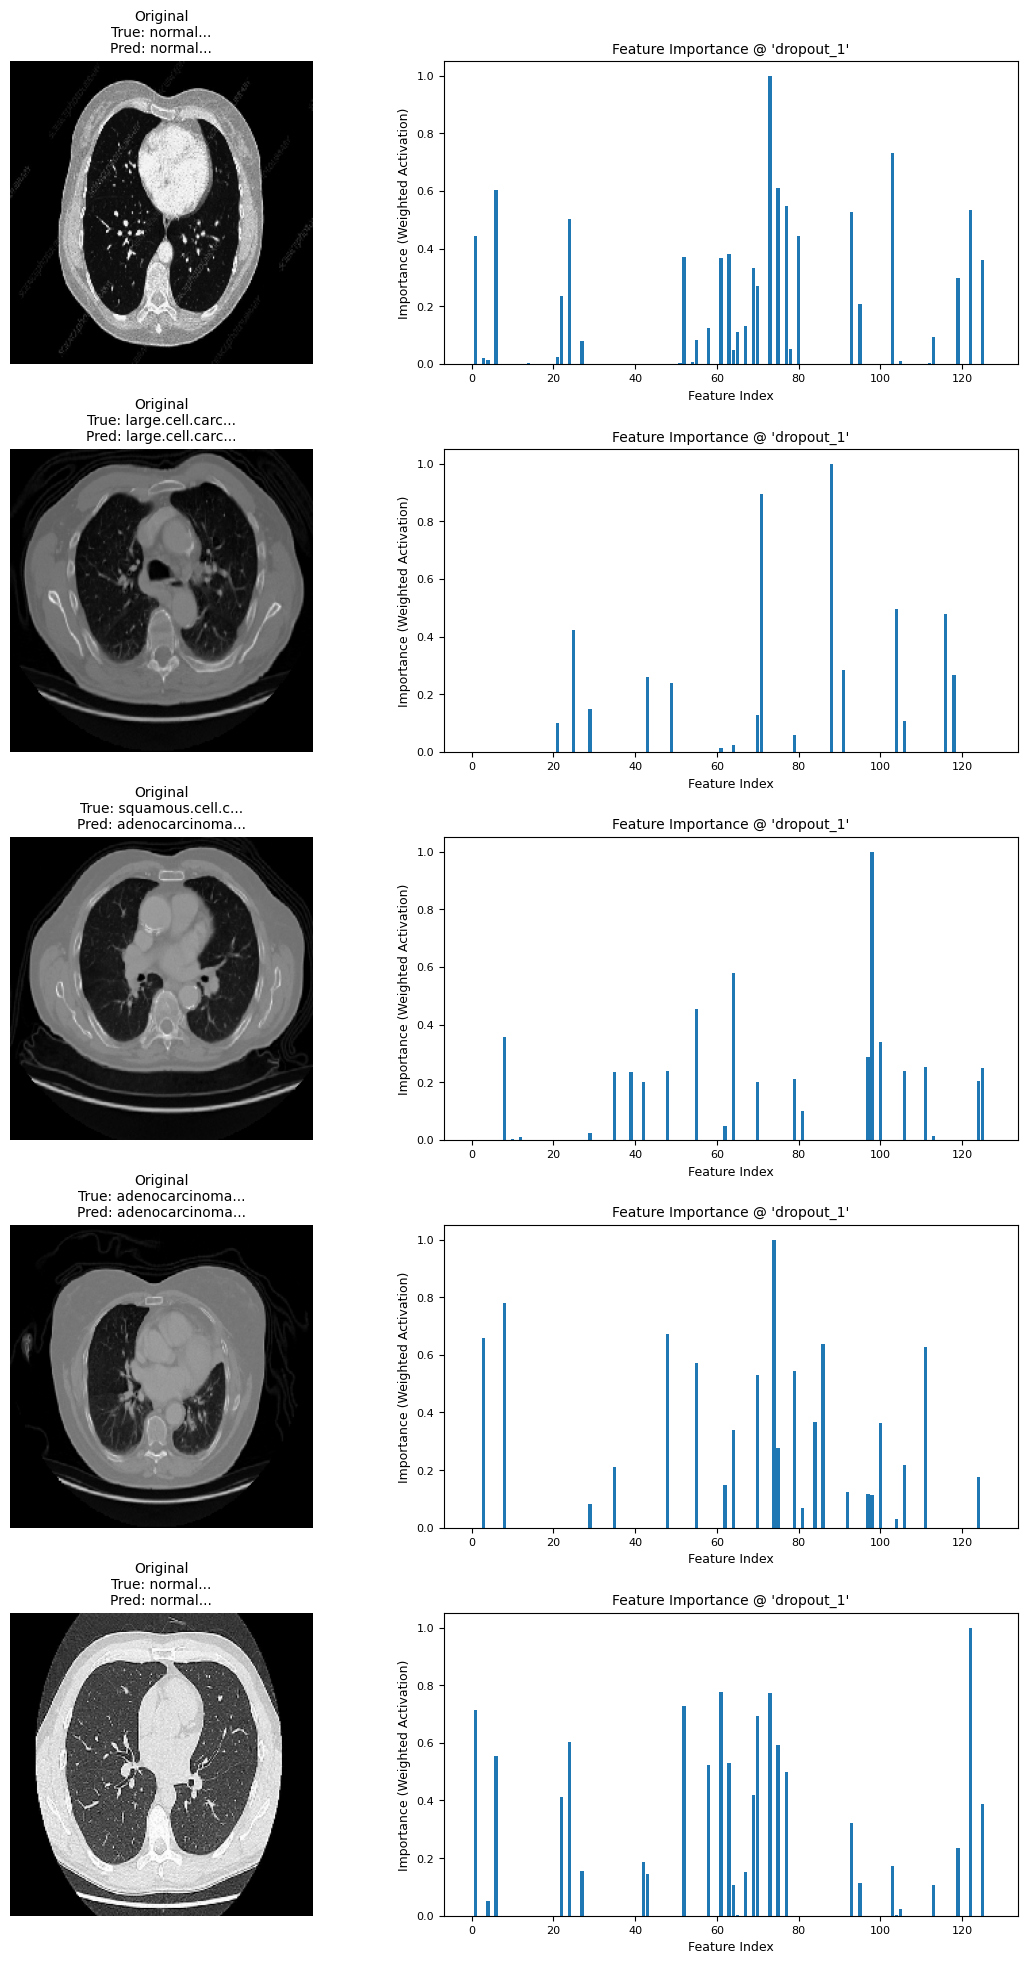

In [11]:
# Cell 9: Grad-CAM Visualization (Targeting layer BEFORE final Dense)

# --- Imports ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import random
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

print("Setting up Grad-CAM functions (Targeting classifier input)...")

# --- Helper Functions ---
def preprocess_image_for_gradcam(img_path, target_size=(224, 224)):
    # (Keep function)
    try:
        img = keras_image.load_img(img_path, target_size=target_size)
        img_array = keras_image.img_to_array(img)
        img_array_orig_scaled = img_array.astype(np.float32) / 255.0
        img_array_expanded = np.expand_dims(img_array_orig_scaled, axis=0)
        return img_array_expanded, img_array_orig_scaled
    except FileNotFoundError: print(f"ERROR: Image file not found at {img_path}"); return None, None
    except Exception as e: print(f"ERROR: Could not load/preprocess image {img_path}: {e}"); return None, None

def overlay_gradcam_heatmap(heatmap, original_img, intensity=0.5, colormap=cv2.COLORMAP_JET):
    # (Keep function)
    # --- IMPORTANT MODIFICATION FOR 1D Heatmap ---
    # This function now needs to handle a 1D heatmap (output of Dense/Dropout)
    # It cannot be directly overlaid spatially. We'll just return the heatmap itself.
    # The visualization part below will need to handle this differently.

    # Normalize heatmap 0-1
    heatmap_norm = heatmap - np.min(heatmap)
    if np.max(heatmap_norm) > 1e-8: heatmap_norm /= np.max(heatmap_norm)
    else: heatmap_norm = np.zeros_like(heatmap)

    print("Note: Overlay not directly applicable for non-spatial heatmap. Returning normalized heatmap.")
    # We can't meaningfully overlay a 1D vector spatially.
    # For visualization, we might plot the heatmap values directly as a bar chart or line.
    # Returning the normalized heatmap vector itself.
    return heatmap_norm # Return the 1D normalized heatmap


# --- Manual Grad-CAM for Non-Spatial Layers ---
def make_gradcam_nonspatial_target(img_array_tf, model, target_layer_name, pred_index=None):
    """Targets a non-spatial layer (like Dense/Dropout) output for CAM-like analysis."""
    try:
        target_layer = model.get_layer(target_layer_name)
        print(f"  Targeting non-spatial layer: {target_layer.name} ({target_layer.output.name})")
    except Exception as e:
        print(f"  ERROR getting target layer '{target_layer_name}': {e}")
        return None

    try:
        # Model to get target layer output and final predictions
        gradient_model = Model(
            inputs=model.inputs,
            outputs=[target_layer.output, model.output]
        )
        print("  Gradient model created successfully.")
    except ValueError as e_build: # Catch the persistent error if it still happens
        print(f"  ERROR: Failed to build Keras gradient model (non-spatial target): {e_build}")
        return None
    except Exception as e_other_build:
        print(f"  ERROR during gradient model creation: {e_other_build}")
        return None

    with tf.GradientTape() as tape:
        target_activations_tape, preds_tape = gradient_model(img_array_tf, training=False)
        tape.watch(target_activations_tape) # Watch the target layer's output

        if pred_index is None:
            pred_index = tf.argmax(preds_tape[0])
        class_channel = preds_tape[:, pred_index]

    grads = tape.gradient(class_channel, target_activations_tape)

    if grads is None:
        print("  ERROR: Gradients are None (Non-spatial target).")
        return None
    print(f"  Gradients calculated for class index: {pred_index.numpy()}")

    # For non-spatial layers (like Dense/Dropout output), grads and activations are typically (batch, features)
    # Pooled grads become (features,)
    pooled_grads = tf.reduce_mean(grads, axis=0).numpy() # Average over batch dim if present (usually 1)
    target_activations_np = target_activations_tape[0].numpy() # Remove batch dim: shape (features,)

    # Calculate "heatmap" - which is just weighted activations for 1D
    # This represents the importance of each feature in the target layer
    heatmap_1d = target_activations_np * pooled_grads # Shape (features,)
    heatmap_1d = np.maximum(heatmap_1d, 0) # ReLU

    # Normalize (optional, good for consistent visualization)
    if np.max(heatmap_1d) > 1e-8:
        heatmap_1d /= np.max(heatmap_1d)
    else:
         heatmap_1d = np.zeros_like(heatmap_1d)


    print(f"  Non-spatial 'heatmap' (feature importance) generated, shape: {heatmap_1d.shape}")
    return heatmap_1d

# --- Main Visualization ---
NUM_SAMPLES_TO_VISUALIZE = 5
if 'loaded_model' in globals() and loaded_model is not None and 'test_generator' in globals():
    # <<< --- TARGET THE LAYER *BEFORE* THE FINAL DENSE LAYER --- <<<
    # Look at your model summary from Cell 4 to confirm the names:
    # Likely 'dropout_1' (output shape (None, 128))
    TARGET_LAYER_NAME = 'dropout_1' # Target the output of this layer
    print(f"\nAttempting CAM-like analysis targeting layer: '{TARGET_LAYER_NAME}' (Output Before Final Dense)")

    # --- Get Sample Images --- (Keep code)
    try:
        test_generator.reset()
        all_filenames = test_generator.filenames
        all_classes = test_generator.classes
        total_samples = len(all_filenames)
        if total_samples == 0: raise ValueError("Test generator has no samples!")
        num_to_show = min(NUM_SAMPLES_TO_VISUALIZE, total_samples)
        sample_indices = random.sample(range(total_samples), num_to_show)
        sample_files = [os.path.join(test_generator.directory, all_filenames[idx]) for idx in sample_indices]
        sample_true_labels = [all_classes[idx] for idx in sample_indices]
        print(f"Retrieved {len(sample_files)} sample files.")
    except Exception as e:
         print(f"ERROR retrieving sample files: {e}")
         sample_files = []


    # --- Plotting (Modified for 1D heatmap) ---
    if sample_files:
        num_cols = 2 # Original image + Feature importance plot
        num_rows = len(sample_files)
        plt.figure(figsize=(num_cols * 6, num_rows * 4)) # Adjust figsize

        for i, (img_path, true_label_idx) in enumerate(zip(sample_files, sample_true_labels)):
            print(f"\nProcessing: {os.path.basename(img_path)}")
            try:
                img_array_processed, img_original_scaled = preprocess_image_for_gradcam(img_path, target_size=IMAGE_SIZE)
                if img_array_processed is None: continue
                img_tf = tf.constant(img_array_processed)

                # --- Generate Feature Importance Vector ---
                feature_importance = make_gradcam_nonspatial_target(
                    img_tf,
                    loaded_model,
                    TARGET_LAYER_NAME # Pass the name of the Dropout/Dense layer
                    # pred_index will be calculated inside
                )

                # Get prediction info
                preds = loaded_model.predict(img_array_processed, verbose=0)
                pred_idx = np.argmax(preds[0])
                pred_score = preds[0][pred_idx]
                print(f"  Pred: {class_labels[pred_idx]} ({pred_score:.3f}) | True: {class_labels[true_label_idx]}")

                # Plot Original Image
                ax1 = plt.subplot(num_rows, num_cols, i * num_cols + 1)
                ax1.imshow(img_original_scaled)
                title_str = f"Original\nTrue: {class_labels[true_label_idx][:15]}...\nPred: {class_labels[pred_idx][:15]}..."
                if feature_importance is None: title_str += "\n(CAM ERROR)"
                ax1.set_title(title_str, fontsize=10)
                ax1.axis('off')

                # Plot Feature Importance if generated
                ax2 = plt.subplot(num_rows, num_cols, i * num_cols + 2)
                if feature_importance is None:
                    print(f"  Skipping importance plot for {os.path.basename(img_path)}.")
                    ax2.set_title(f"Feat. Import. (Lyr: {TARGET_LAYER_NAME})\nERROR", fontsize=10)
                    ax2.axis('off')
                    continue

                print(f"  Feature importance generated (shape: {feature_importance.shape}, Min: {feature_importance.min():.2f}, Max: {feature_importance.max():.2f})")

                # --- Visualize the 1D heatmap (feature importance) ---
                # Example: Bar chart of the feature importances
                features = np.arange(len(feature_importance))
                ax2.bar(features, feature_importance)
                ax2.set_title(f"Feature Importance @ '{TARGET_LAYER_NAME}'", fontsize=10)
                ax2.set_xlabel("Feature Index", fontsize=9)
                ax2.set_ylabel("Importance (Weighted Activation)", fontsize=9)
                ax2.tick_params(axis='x', labelsize=8)
                ax2.tick_params(axis='y', labelsize=8)


            except Exception as e:
                print(f"  UNEXPECTED ERROR processing image {img_path}: {e}")
                import traceback
                traceback.print_exc()
                ax1 = plt.subplot(num_rows, num_cols, i * num_cols + 1); ax1.set_title('Original - UNEXPECTED ERROR'); ax1.axis('off')
                ax2 = plt.subplot(num_rows, num_cols, i * num_cols + 2); ax2.set_title('Importance - UNEXPECTED ERROR'); ax2.axis('off')


        plt.tight_layout(pad=2.0)
        plt.show()

else:
    print("\nERROR: 'loaded_model' or 'test_generator' not defined. Ensure previous cells ran correctly.")

In [12]:
# Cell 6: Execute Prediction

# --- Provide the path to the CT scan image you want to classify ---
# --- *** IMPORTANT: CHANGE THIS PATH *** ---
# OLD Example Path (Caused error):
# image_to_predict_path = '/content/drive/MyDrive/data/ct/Data/test/normal/10 - Copy.png'

# NEW Corrected Path (Paste the path you copied from the file browser here):
image_to_predict_path = '/content/drive/MyDrive/data/ct/Data/valid/normal/003828_02_01_174.png' # <<< PASTE CORRECT PATH HERE

# --- Run Prediction ---
if 'loaded_model' in globals() and loaded_model is not None:
    print(f"Attempting to predict on: {image_to_predict_path}") # Added print for checking path used
    if os.path.exists(image_to_predict_path):
         predicted_class, confidence = predict_ct_scan(image_to_predict_path, loaded_model, class_labels)
         print(f"\nPrediction Result: Class = {predicted_class}, Confidence = {confidence:.2%}")

         # Store results for the report cell
         report_image_path = image_to_predict_path
         report_prediction = predicted_class
         report_confidence = confidence

    else:
         print(f"\nERROR: Image path not found: {image_to_predict_path}") # This error will print if path is wrong again
         report_prediction = "File Not Found"

else:
    print("\nERROR: Model not loaded correctly. Cannot predict.")
    report_prediction = "Model Not Loaded"

Attempting to predict on: /content/drive/MyDrive/data/ct/Data/valid/normal/003828_02_01_174.png

Predicting for image: 003828_02_01_174.png
-> Predicted Class: normal
-> Confidence: 0.9341

Prediction Result: Class = normal, Confidence = 93.41%


In [13]:
# --- Simple Report Function ---
def generate_simple_report(image_path, predicted_class, confidence_score, model_name="mobilenetv2_ct_final.keras"):
    """Creates a basic text report string."""
    if predicted_class in ["Error Preprocessing", "Index Error", "Prediction Error", "File Not Found", "Model Not Loaded"]:
        report = f"--- CT Scan Analysis Report ---\n\n"
        report += f"Image File:       {os.path.basename(image_path)}\n"
        report += f"Analysis Status:  FAILED ({predicted_class})\n\n"
        report += "Disclaimer: AI analysis could not be completed.\n"
        return report

    # Format the report for successful prediction
    report = f"--- CT Scan Analysis Report ---\n\n"
    report += f"Image File:       {os.path.basename(image_path)}\n\n"
    report += f"--- Automated AI Finding ---\n"
    report += f"Predicted Condition: {predicted_class}\n"
    report += f"Confidence Score:    {confidence_score:.2%}\n\n"
    report += f"--- Disclaimer ---\n"
    report += f"This prediction was generated by the AI model '{model_name}'.\n"
    report += "It is intended for informational/research purposes ONLY.\n"
    report += "*** This is NOT a medical diagnosis. ***\n"
    report += "Always consult a qualified radiologist and healthcare provider for actual diagnosis and medical advice."
    return report

print("Report generation function defined.")

Report generation function defined.


In [14]:
# --- Generate and Print the Report ---
if 'report_prediction' in globals():
    simple_report_text = generate_simple_report(report_image_path, report_prediction, report_confidence, os.path.basename(KERAS_MODEL_LOAD_PATH))
    print("\n" + "="*30 + " REPORT " + "="*30)
    print(simple_report_text)
    print("="*68)

    # --- Optional: Save the report to a file ---
    # report_filename = f"{os.path.splitext(os.path.basename(report_image_path))[0]}_report.txt"
    # report_save_dir = os.path.join(PROJECT_DIR, 'reports') # Create this folder if needed
    # os.makedirs(report_save_dir, exist_ok=True)
    # report_full_path = os.path.join(report_save_dir, report_filename)
    # try:
    #     with open(report_full_path, 'w') as f:
    #         f.write(simple_report_text)
    #     print(f"\nReport saved to: {report_full_path}")
    # except Exception as e:
    #     print(f"\nError saving report: {e}")

else:
    print("\nCannot generate report because prediction results are missing.")


============================== REPORT ==============================
--- CT Scan Analysis Report ---

Image File:       003828_02_01_174.png

--- Automated AI Finding ---
Predicted Condition: normal
Confidence Score:    93.41%

--- Disclaimer ---
This prediction was generated by the AI model 'mobilenetv2_ct_final.keras'.
It is intended for informational/research purposes ONLY.
*** This is NOT a medical diagnosis. ***
Always consult a qualified radiologist and healthcare provider for actual diagnosis and medical advice.


Setting up Grad-CAM functions (Targeting classifier input)...

Attempting CAM-like analysis targeting layer: 'dropout_1' (Output Before Final Dense)
Retrieved 5 sample files.

Processing: 7 - Copy (2).png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model created successfully.
  Gradients calculated for class index: 2
  Non-spatial 'heatmap' (feature importance) generated, shape: (128,)
  Pred: normal (1.000) | True: normal
  Feature importance generated (shape: (128,), Min: 0.00, Max: 1.00)

Processing: 000141 (4).png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model created successfully.
  Gradients calculated for class index: 1
  Non-spatial 'heatmap' (feature importance) generated, shape: (128,)
  Pred: large.cell.carcinoma (0.422) | True: squamous.cell.carcinoma
  Feature importance generated (shape: (128,), Min: 0.00, Max: 1.00)

Processing: 000155.png
  Targeting non-spatial layer: dropout_1 (keras_tensor_485)
  Gradient model

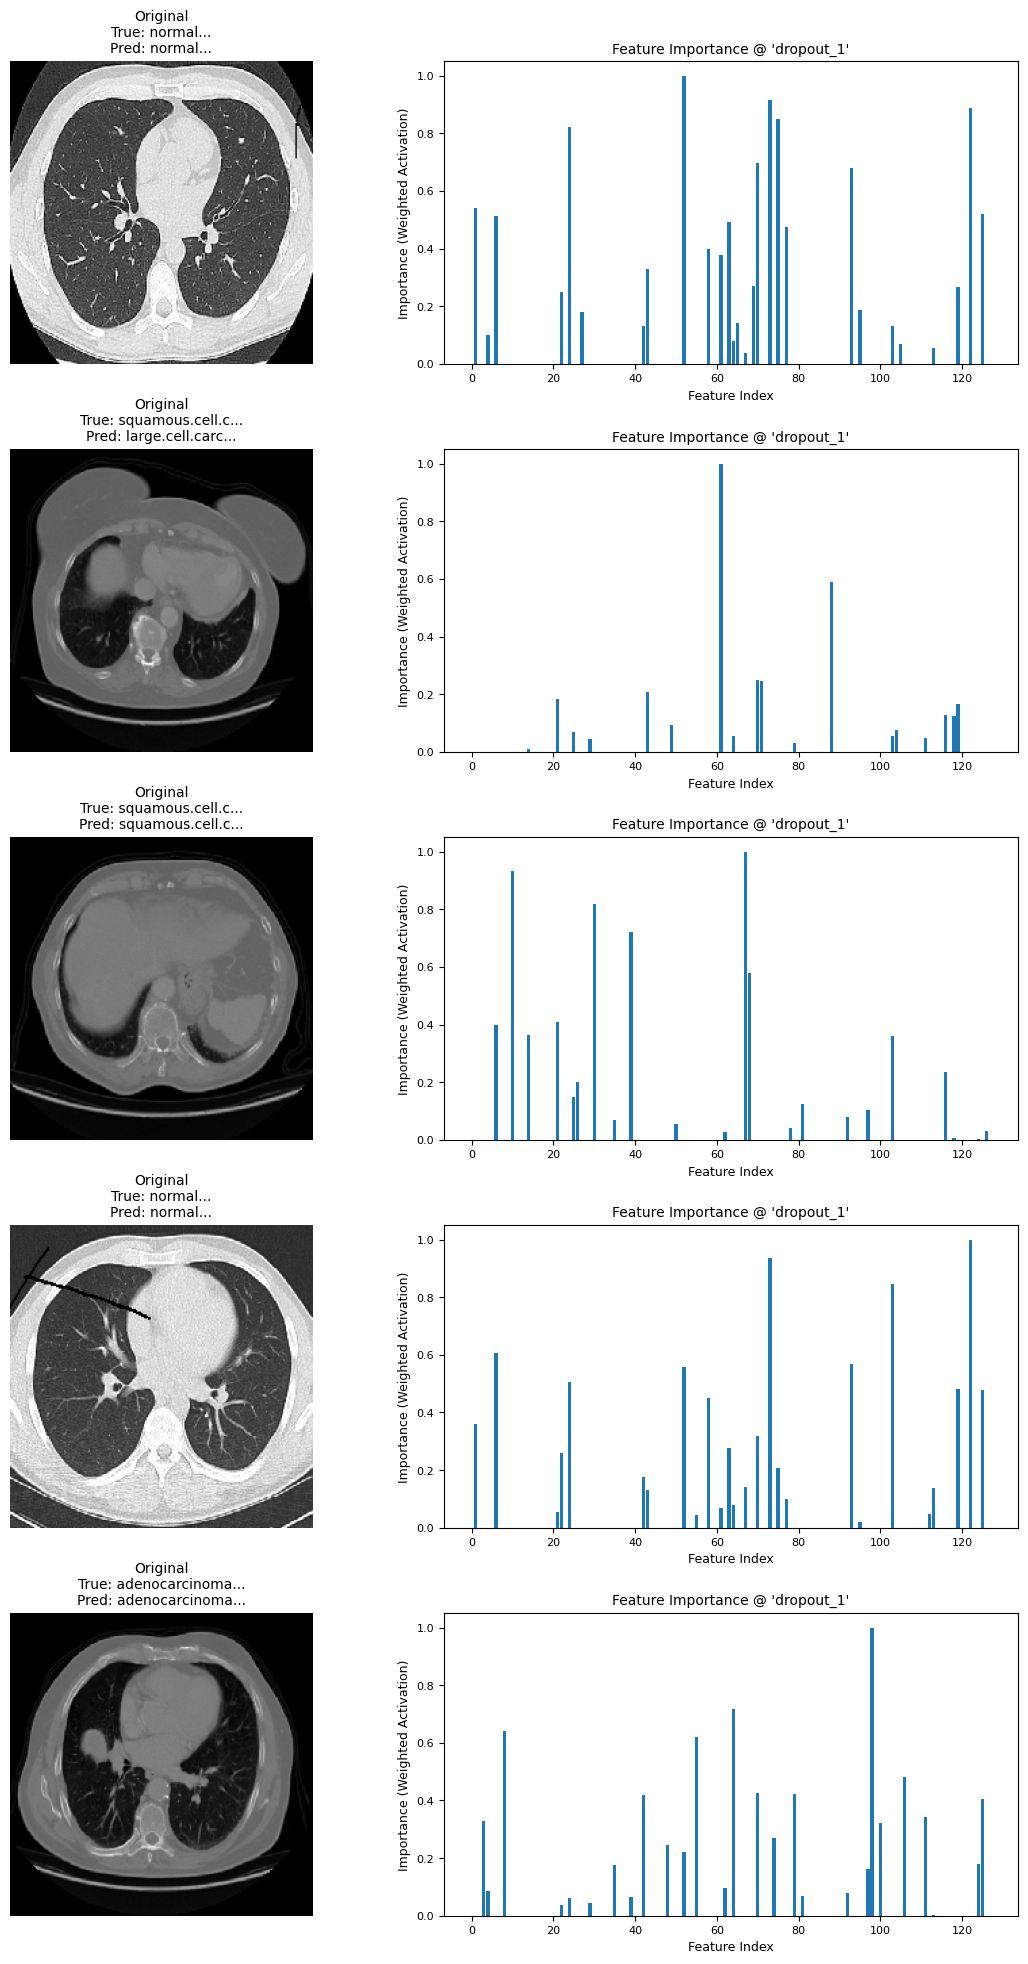

In [15]:
# Cell 9: Grad-CAM Visualization (Targeting layer BEFORE final Dense)

# --- Imports ---
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import random
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import Model

print("Setting up Grad-CAM functions (Targeting classifier input)...")

# --- Helper Functions ---
def preprocess_image_for_gradcam(img_path, target_size=(224, 224)):
    # (Keep function)
    try:
        img = keras_image.load_img(img_path, target_size=target_size)
        img_array = keras_image.img_to_array(img)
        img_array_orig_scaled = img_array.astype(np.float32) / 255.0
        img_array_expanded = np.expand_dims(img_array_orig_scaled, axis=0)
        return img_array_expanded, img_array_orig_scaled
    except FileNotFoundError: print(f"ERROR: Image file not found at {img_path}"); return None, None
    except Exception as e: print(f"ERROR: Could not load/preprocess image {img_path}: {e}"); return None, None

def overlay_gradcam_heatmap(heatmap, original_img, intensity=0.5, colormap=cv2.COLORMAP_JET):
    # (Keep function)
    # --- IMPORTANT MODIFICATION FOR 1D Heatmap ---
    # This function now needs to handle a 1D heatmap (output of Dense/Dropout)
    # It cannot be directly overlaid spatially. We'll just return the heatmap itself.
    # The visualization part below will need to handle this differently.

    # Normalize heatmap 0-1
    heatmap_norm = heatmap - np.min(heatmap)
    if np.max(heatmap_norm) > 1e-8: heatmap_norm /= np.max(heatmap_norm)
    else: heatmap_norm = np.zeros_like(heatmap)

    print("Note: Overlay not directly applicable for non-spatial heatmap. Returning normalized heatmap.")
    # We can't meaningfully overlay a 1D vector spatially.
    # For visualization, we might plot the heatmap values directly as a bar chart or line.
    # Returning the normalized heatmap vector itself.
    return heatmap_norm # Return the 1D normalized heatmap


# --- Manual Grad-CAM for Non-Spatial Layers ---
def make_gradcam_nonspatial_target(img_array_tf, model, target_layer_name, pred_index=None):
    """Targets a non-spatial layer (like Dense/Dropout) output for CAM-like analysis."""
    try:
        target_layer = model.get_layer(target_layer_name)
        print(f"  Targeting non-spatial layer: {target_layer.name} ({target_layer.output.name})")
    except Exception as e:
        print(f"  ERROR getting target layer '{target_layer_name}': {e}")
        return None

    try:
        # Model to get target layer output and final predictions
        gradient_model = Model(
            inputs=model.inputs,
            outputs=[target_layer.output, model.output]
        )
        print("  Gradient model created successfully.")
    except ValueError as e_build: # Catch the persistent error if it still happens
        print(f"  ERROR: Failed to build Keras gradient model (non-spatial target): {e_build}")
        return None
    except Exception as e_other_build:
        print(f"  ERROR during gradient model creation: {e_other_build}")
        return None

    with tf.GradientTape() as tape:
        target_activations_tape, preds_tape = gradient_model(img_array_tf, training=False)
        tape.watch(target_activations_tape) # Watch the target layer's output

        if pred_index is None:
            pred_index = tf.argmax(preds_tape[0])
        class_channel = preds_tape[:, pred_index]

    grads = tape.gradient(class_channel, target_activations_tape)

    if grads is None:
        print("  ERROR: Gradients are None (Non-spatial target).")
        return None
    print(f"  Gradients calculated for class index: {pred_index.numpy()}")

    # For non-spatial layers (like Dense/Dropout output), grads and activations are typically (batch, features)
    # Pooled grads become (features,)
    pooled_grads = tf.reduce_mean(grads, axis=0).numpy() # Average over batch dim if present (usually 1)
    target_activations_np = target_activations_tape[0].numpy() # Remove batch dim: shape (features,)

    # Calculate "heatmap" - which is just weighted activations for 1D
    # This represents the importance of each feature in the target layer
    heatmap_1d = target_activations_np * pooled_grads # Shape (features,)
    heatmap_1d = np.maximum(heatmap_1d, 0) # ReLU

    # Normalize (optional, good for consistent visualization)
    if np.max(heatmap_1d) > 1e-8:
        heatmap_1d /= np.max(heatmap_1d)
    else:
         heatmap_1d = np.zeros_like(heatmap_1d)


    print(f"  Non-spatial 'heatmap' (feature importance) generated, shape: {heatmap_1d.shape}")
    return heatmap_1d

# --- Main Visualization ---
NUM_SAMPLES_TO_VISUALIZE = 5
if 'loaded_model' in globals() and loaded_model is not None and 'test_generator' in globals():
    # <<< --- TARGET THE LAYER *BEFORE* THE FINAL DENSE LAYER --- <<<
    # Look at your model summary from Cell 4 to confirm the names:
    # Likely 'dropout_1' (output shape (None, 128))
    TARGET_LAYER_NAME = 'dropout_1' # Target the output of this layer
    print(f"\nAttempting CAM-like analysis targeting layer: '{TARGET_LAYER_NAME}' (Output Before Final Dense)")

    # --- Get Sample Images --- (Keep code)
    try:
        test_generator.reset()
        all_filenames = test_generator.filenames
        all_classes = test_generator.classes
        total_samples = len(all_filenames)
        if total_samples == 0: raise ValueError("Test generator has no samples!")
        num_to_show = min(NUM_SAMPLES_TO_VISUALIZE, total_samples)
        sample_indices = random.sample(range(total_samples), num_to_show)
        sample_files = [os.path.join(test_generator.directory, all_filenames[idx]) for idx in sample_indices]
        sample_true_labels = [all_classes[idx] for idx in sample_indices]
        print(f"Retrieved {len(sample_files)} sample files.")
    except Exception as e:
         print(f"ERROR retrieving sample files: {e}")
         sample_files = []


    # --- Plotting (Modified for 1D heatmap) ---
    if sample_files:
        num_cols = 2 # Original image + Feature importance plot
        num_rows = len(sample_files)
        plt.figure(figsize=(num_cols * 6, num_rows * 4)) # Adjust figsize

        for i, (img_path, true_label_idx) in enumerate(zip(sample_files, sample_true_labels)):
            print(f"\nProcessing: {os.path.basename(img_path)}")
            try:
                img_array_processed, img_original_scaled = preprocess_image_for_gradcam(img_path, target_size=IMAGE_SIZE)
                if img_array_processed is None: continue
                img_tf = tf.constant(img_array_processed)

                # --- Generate Feature Importance Vector ---
                feature_importance = make_gradcam_nonspatial_target(
                    img_tf,
                    loaded_model,
                    TARGET_LAYER_NAME # Pass the name of the Dropout/Dense layer
                    # pred_index will be calculated inside
                )

                # Get prediction info
                preds = loaded_model.predict(img_array_processed, verbose=0)
                pred_idx = np.argmax(preds[0])
                pred_score = preds[0][pred_idx]
                print(f"  Pred: {class_labels[pred_idx]} ({pred_score:.3f}) | True: {class_labels[true_label_idx]}")

                # Plot Original Image
                ax1 = plt.subplot(num_rows, num_cols, i * num_cols + 1)
                ax1.imshow(img_original_scaled)
                title_str = f"Original\nTrue: {class_labels[true_label_idx][:15]}...\nPred: {class_labels[pred_idx][:15]}..."
                if feature_importance is None: title_str += "\n(CAM ERROR)"
                ax1.set_title(title_str, fontsize=10)
                ax1.axis('off')

                # Plot Feature Importance if generated
                ax2 = plt.subplot(num_rows, num_cols, i * num_cols + 2)
                if feature_importance is None:
                    print(f"  Skipping importance plot for {os.path.basename(img_path)}.")
                    ax2.set_title(f"Feat. Import. (Lyr: {TARGET_LAYER_NAME})\nERROR", fontsize=10)
                    ax2.axis('off')
                    continue

                print(f"  Feature importance generated (shape: {feature_importance.shape}, Min: {feature_importance.min():.2f}, Max: {feature_importance.max():.2f})")

                # --- Visualize the 1D heatmap (feature importance) ---
                # Example: Bar chart of the feature importances
                features = np.arange(len(feature_importance))
                ax2.bar(features, feature_importance)
                ax2.set_title(f"Feature Importance @ '{TARGET_LAYER_NAME}'", fontsize=10)
                ax2.set_xlabel("Feature Index", fontsize=9)
                ax2.set_ylabel("Importance (Weighted Activation)", fontsize=9)
                ax2.tick_params(axis='x', labelsize=8)
                ax2.tick_params(axis='y', labelsize=8)


            except Exception as e:
                print(f"  UNEXPECTED ERROR processing image {img_path}: {e}")
                import traceback
                traceback.print_exc()
                ax1 = plt.subplot(num_rows, num_cols, i * num_cols + 1); ax1.set_title('Original - UNEXPECTED ERROR'); ax1.axis('off')
                ax2 = plt.subplot(num_rows, num_cols, i * num_cols + 2); ax2.set_title('Importance - UNEXPECTED ERROR'); ax2.axis('off')


        plt.tight_layout(pad=2.0)
        plt.show()

else:
    print("\nERROR: 'loaded_model' or 'test_generator' not defined. Ensure previous cells ran correctly.")

Installing required packages...
Package installation complete.

Importing libraries...
TensorFlow Version: 2.18.0
All imports successful.

Setting up configuration...
Configuration:
Data Root: /content/drive/MyDrive/data/ct/Data
Model Path: /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_final.keras
Image Size: (224, 224)

Setting up environment...
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully

Verifying paths...
Model path: ✅ /content/drive/MyDrive/data/ct/models/mobilenetv2_ct_final.keras
Sample image path: ✅ /content/drive/MyDrive/data/ct/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000000 (6).png
Data root directory: ✅ /content/drive/MyDrive/data/ct/Data

Setting up data generators...
Training directory: ✅ /content/drive/MyDrive/data/ct/Data/train
Test directory: ✅ /content/drive/MyDrive/data/ct/Data/test
Found 613 images belo

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_dense (Dense)                 │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting CT Scan Analysis Pipeline...

=== SINGLE IMAGE PREDICTION ===

Single Image Prediction Results:
Image: 000000 (6).png
Predicted: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib (Index: 0)
Confidence: 63.03%

=== MODEL EVALUATION ===

Evaluating on 315 samples (10 steps)...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8276 - auc: 0.9646 - loss: 0.4877 - precision: 0.8589 - recall: 0.7555

Evaluation Metrics:
loss: 0.6181
compile_metrics: 0.7206

=== DETAILED ANALYSIS ===
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step

Classification Report:
                                                  precision    recall  f1-score   support

      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.63      0.89      0.74       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.65      0.67      0.66        51
                                          normal       1.00      0.98      0.99        54
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.85      0.37      0.51        90

                                        accuracy                           0.72       315
                                       macro avg       0.78      0.73      0.72       315
                                    weighted avg       0.76      0.72      0.70       315


Conf

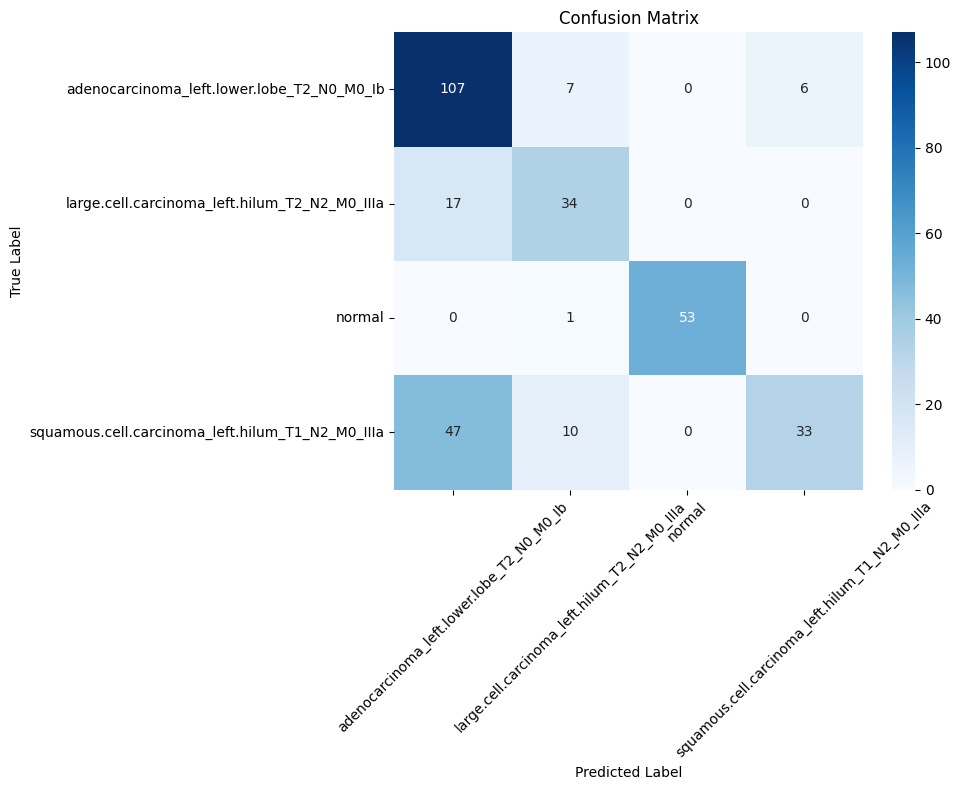


=== REPORT GENERATION ===

✅ PDF report generated: /content/drive/MyDrive/data/ct/reports/CT_Report_20250401_092222.pdf



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== ANALYSIS COMPLETE ===

Pipeline completed successfully!


In [16]:
# ==============================================================================
#                          COMPLETE CT SCAN ANALYSIS PIPELINE
# ==============================================================================
# Run this entire block as a single cell in Google Colab.

# --- 0. Install Dependencies ---
print("Installing required packages...")
!pip install fpdf2 -q
!pip install tensorflow -q
print("Package installation complete.")

# --- 1. Imports ---
print("\nImporting libraries...")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import random
import datetime
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from fpdf import FPDF
from fpdf.enums import XPos, YPos
from google.colab import files

print(f"TensorFlow Version: {tf.__version__}")
print("All imports successful.")

# --- 2. Configuration ---
print("\nSetting up configuration...")

# Path Configuration
DATA_ROOT = '/content/drive/MyDrive/data/ct/Data'
PROJECT_DIR = '/content/drive/MyDrive/data/ct'
MODEL_FILENAME = 'mobilenetv2_ct_final.keras'
KERAS_MODEL_LOAD_PATH = os.path.join(PROJECT_DIR, 'models', MODEL_FILENAME)
SINGLE_IMAGE_PREDICT_PATH = '/content/drive/MyDrive/data/ct/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000000 (6).png'

# Model Parameters
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32
NUM_CLASSES = 4  # Update based on your model

print("Configuration:")
print(f"Data Root: {DATA_ROOT}")
print(f"Model Path: {KERAS_MODEL_LOAD_PATH}")
print(f"Image Size: {IMAGE_SIZE}")

# --- 3. Helper Functions ---
def verify_path(path, description):
    """Verify path exists with visual feedback"""
    exists = os.path.exists(path)
    print(f"{description}: {'✅' if exists else '❌'} {path}")
    if not exists:
        raise FileNotFoundError(f"Path not found: {path}")
    return exists

def get_timestamped_filename(prefix="CT_Report"):
    """Generate unique filename with timestamp"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{prefix}_{timestamp}.pdf"

def save_figure_to_temp(fig, filename="temp_plot.png"):
    """Save matplotlib figure to temporary file"""
    try:
        path = os.path.join("/content", filename)
        fig.savefig(path, bbox_inches='tight', dpi=150)
        return path
    except Exception as e:
        print(f"❌ Could not save figure: {str(e)}")
        return None

# --- 4. Setup Environment ---
print("\nSetting up environment...")

# Mount Google Drive
print("Mounting Google Drive...")
try:
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully")
except Exception as e:
    print(f"❌ Failed to mount Google Drive: {str(e)}")
    raise SystemExit("Cannot continue without Drive access")

# Verify critical paths
print("\nVerifying paths...")
verify_path(KERAS_MODEL_LOAD_PATH, "Model path")
verify_path(SINGLE_IMAGE_PREDICT_PATH, "Sample image path")
verify_path(DATA_ROOT, "Data root directory")

# --- 5. Data Pipeline ---
print("\nSetting up data generators...")

try:
    # Setup directories
    TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
    TEST_DIR = os.path.join(DATA_ROOT, 'test')
    verify_path(TRAIN_DIR, "Training directory")
    verify_path(TEST_DIR, "Test directory")

    # Create generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Training generator (for class info)
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Get class information
    class_labels = list(train_generator.class_indices.keys())
    print("\nClass Information:")
    print(f"Class Labels: {class_labels}")
    print(f"Class Indices: {train_generator.class_indices}")

    # Test generator
    test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print(f"\n✅ Data generators created with {test_generator.samples} test samples")

except Exception as e:
    print(f"\n❌ Data pipeline setup failed: {str(e)}")
    raise SystemExit("Cannot continue without proper data setup")

# --- 6. Model Loading ---
print(f"\nLoading model from: {KERAS_MODEL_LOAD_PATH}")

try:
    # Load and compile model
    model = load_model(KERAS_MODEL_LOAD_PATH)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    print("✅ Model loaded and compiled successfully")
    model.summary()

except Exception as e:
    print(f"\n❌ Model loading failed: {str(e)}")
    raise SystemExit("Cannot continue without model")

# --- 7. Prediction Functions ---
def predict_single_image(image_path, model, class_labels):
    """Make prediction on a single image"""
    try:
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at {image_path}")

        # Load and preprocess image
        img = keras_image.load_img(image_path, target_size=IMAGE_SIZE)
        img_array = keras_image.img_to_array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_batch, verbose=0)[0]
        pred_index = np.argmax(predictions)
        confidence = predictions[pred_index]
        pred_label = class_labels[pred_index]

        print(f"\nSingle Image Prediction Results:")
        print(f"Image: {os.path.basename(image_path)}")
        print(f"Predicted: {pred_label} (Index: {pred_index})")
        print(f"Confidence: {confidence:.2%}")

        return pred_label, confidence, image_path

    except Exception as e:
        print(f"\n❌ Prediction failed: {str(e)}")
        return "Error", 0.0, image_path

# --- 8. Evaluation Functions ---
def evaluate_model(model, test_generator):
    """Evaluate model on test set"""
    try:
        test_steps = math.ceil(test_generator.samples / test_generator.batch_size)
        print(f"\nEvaluating on {test_generator.samples} samples ({test_steps} steps)...")

        results = model.evaluate(test_generator, steps=test_steps, verbose=1)

        # Process results
        if hasattr(model, 'metrics_names'):
            metrics = dict(zip(model.metrics_names, results))
        else:
            metrics = {'loss': results[0], 'accuracy': results[1]}

        print("\nEvaluation Metrics:")
        for name, value in metrics.items():
            print(f"{name}: {value:.4f}")

        return metrics

    except Exception as e:
        print(f"\n❌ Evaluation failed: {str(e)}")
        return {'error': str(e)}

def generate_classification_report(model, test_generator, class_labels):
    """Generate detailed classification report"""
    try:
        test_generator.reset()
        predictions = model.predict(test_generator, verbose=1)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes

        # Classification Report
        cr = classification_report(
            true_classes,
            predicted_classes,
            target_names=class_labels,
            output_dict=True
        )

        print("\nClassification Report:")
        print(classification_report(
            true_classes,
            predicted_classes,
            target_names=class_labels
        ))

        # Confusion Matrix
        cm = confusion_matrix(true_classes, predicted_classes)
        print("\nConfusion Matrix:")
        print(cm)

        # Plot CM
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_labels,
                   yticklabels=class_labels)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()

        cm_figure = plt.gcf()
        plt.show()

        return cr, cm_figure

    except Exception as e:
        print(f"\n❌ Detailed analysis failed: {str(e)}")
        return {'error': str(e)}, None

# --- 9. PDF Report Generation ---
def create_pdf_report(report_data, filename=None):
    """Generate comprehensive PDF report"""
    try:
        # Create PDF object
        pdf = FPDF()
        pdf.add_page()
        pdf.set_auto_page_break(auto=True, margin=15)

        # --- Title Section ---
        pdf.set_font("Helvetica", 'B', 16)
        pdf.cell(0, 10, "CT Scan Analysis Report", new_x=XPos.LMARGIN, new_y=YPos.NEXT, align='C')
        pdf.set_font("Helvetica", 'I', 10)
        pdf.cell(0, 5, f"Generated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
                new_x=XPos.LMARGIN, new_y=YPos.NEXT, align='C')
        pdf.ln(10)

        # --- Single Image Analysis ---
        pdf.set_font("Helvetica", 'B', 14)
        pdf.cell(0, 8, "Single Image Analysis", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.set_font("Helvetica", size=10)

        if report_data.get('image_path') and os.path.exists(report_data['image_path']):
            try:
                # Add image with proper sizing
                with Image.open(report_data['image_path']) as img:
                    aspect = img.height / img.width
                    img_w = 70
                    img_h = img_w * aspect

                    # Ensure image doesn't take too much vertical space
                    if img_h > 100:
                        img_h = 100
                        img_w = img_h / aspect

                    pdf.image(
                        report_data['image_path'],
                        x=pdf.l_margin,
                        y=pdf.get_y(),
                        w=img_w,
                        h=img_h
                    )

                    # Add text beside image
                    text_x = pdf.l_margin + img_w + 5
                    pdf.set_xy(text_x, pdf.get_y())
                    pdf.cell(0, 5, f"File: {os.path.basename(report_data['image_path'])}",
                            new_x=XPos.LMARGIN, new_y=YPos.NEXT)
                    pdf.set_x(text_x)
                    pdf.cell(0, 5, f"Prediction: {report_data['prediction']}",
                            new_x=XPos.LMARGIN, new_y=YPos.NEXT)
                    pdf.set_x(text_x)
                    pdf.cell(0, 5, f"Confidence: {report_data['confidence']:.2%}",
                            new_x=XPos.LMARGIN, new_y=YPos.NEXT)
                    pdf.set_y(max(pdf.get_y(), pdf.get_y() + img_h - 15))
            except Exception as e:
                pdf.cell(0, 5, f"Could not embed image: {str(e)}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        else:
            pdf.cell(0, 5, "Image not available for report", new_x=XPos.LMARGIN, new_y=YPos.NEXT)

        pdf.ln(10)

        # --- Model Performance ---
        pdf.set_font("Helvetica", 'B', 14)
        pdf.cell(0, 8, "Model Performance", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.set_font("Helvetica", size=10)

        if 'metrics' in report_data:
            metrics = report_data['metrics']
            if 'loss' in metrics:
                pdf.cell(0, 5, f"Test Loss: {metrics['loss']:.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
            if 'accuracy' in metrics:
                pdf.cell(0, 5, f"Accuracy: {metrics['accuracy']:.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
            if 'precision' in metrics:
                pdf.cell(0, 5, f"Precision: {metrics['precision']:.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
            if 'recall' in metrics:
                pdf.cell(0, 5, f"Recall: {metrics['recall']:.4f}", new_x=XPos.LMARGIN, new_y=YPos.NEXT)

        pdf.ln(10)

        # --- Confusion Matrix ---
        if report_data.get('cm_figure'):
            pdf.set_font("Helvetica", 'B', 14)
            pdf.cell(0, 8, "Confusion Matrix", new_x=XPos.LMARGIN, new_y=YPos.NEXT)

            cm_path = save_figure_to_temp(report_data['cm_figure'], "confusion_matrix.png")
            if cm_path:
                try:
                    with Image.open(cm_path) as img:
                        aspect = img.height / img.width
                        plot_width = pdf.epw * 0.85
                        plot_height = plot_width * aspect

                        if pdf.get_y() + plot_height > pdf.page_break_trigger:
                            pdf.add_page()

                        pdf.image(cm_path, x=(pdf.w - plot_width)/2, y=None,
                                w=plot_width, h=plot_height)
                        os.remove(cm_path)
                        pdf.ln(5)
                except Exception as e:
                    pdf.cell(0, 5, f"Could not embed confusion matrix: {str(e)}",
                           new_x=XPos.LMARGIN, new_y=YPos.NEXT)

        # --- Disclaimer ---
        pdf.add_page()
        pdf.set_font("Helvetica", 'B', 14)
        pdf.cell(0, 8, "Disclaimer", new_x=XPos.LMARGIN, new_y=YPos.NEXT)
        pdf.set_font("Helvetica", 'I', 10)
        disclaimer = ("This report was generated by an AI model and is intended for "
                     "informational/research purposes only. It is not a medical diagnosis. "
                     "Always consult a qualified radiologist for clinical interpretation.")
        pdf.multi_cell(0, 5, disclaimer)

        # Save PDF
        reports_dir = os.path.join(PROJECT_DIR, 'reports')
        os.makedirs(reports_dir, exist_ok=True)

        # Generate filename if not provided
        if not filename:
            filename = get_timestamped_filename()

        pdf_path = os.path.join(reports_dir, filename)
        pdf.output(pdf_path)

        print(f"\n✅ PDF report generated: {pdf_path}")
        return pdf_path

    except Exception as e:
        print(f"\n❌ PDF generation failed: {str(e)}")
        return None

# --- 10. Main Execution ---
def main():
    """Main execution pipeline"""
    try:
        print("\nStarting CT Scan Analysis Pipeline...")

        # 1. Single Image Prediction
        print("\n=== SINGLE IMAGE PREDICTION ===")
        pred_label, confidence, img_path = predict_single_image(
            SINGLE_IMAGE_PREDICT_PATH, model, class_labels
        )

        # 2. Full Evaluation
        print("\n=== MODEL EVALUATION ===")
        eval_metrics = evaluate_model(model, test_generator)

        # 3. Detailed Analysis
        print("\n=== DETAILED ANALYSIS ===")
        class_report, cm_figure = generate_classification_report(
            model, test_generator, class_labels
        )

        # 4. Generate Report
        print("\n=== REPORT GENERATION ===")
        report_data = {
            'image_path': img_path,
            'prediction': pred_label,
            'confidence': confidence,
            'metrics': eval_metrics,
            'classification_report': class_report,
            'cm_figure': cm_figure
        }

        # Create and optionally download report
        report_path = create_pdf_report(report_data)
        if report_path and os.path.exists(report_path):
            print("\nDownloading report...")
            files.download(report_path)

        print("\n=== ANALYSIS COMPLETE ===")
        return True

    except Exception as e:
        print(f"\n❌ Pipeline execution failed: {str(e)}")
        return False

# Run the pipeline
if __name__ == "__main__":
    success = main()
    if not success:
        print("\nPipeline completed with errors. Please check the output for issues.")
    else:
        print("\nPipeline completed successfully!")